# Lab 3 - Principal Component Analysis

This notebook introduces the Principal Component Analysis, its visualization and spatial analysis.

It is part of the Spatial Cluster Analysis course taught at the University of Chicago in the Winter Quarter of 2025.

Prepared by: Luc Anselin (anselin@uchicago.edu) and Pedro Amaral (pedroamaral@uchicago.edu)

## Preliminaries
We will begin this exercise reviewing the Principal Component Analysis (PCA), a core method of both multivariate statistics and machine learning used for dimension reduction. Dimension reduction is particularly relevant in situations where many variables are available that are highly intercorrelated. In essence, the original variables are replaced by a smaller number of proxies that represent them well in terms of their statistical properties.

### Required packages

The conda enviroment used for this exercise was created from a yml file with the same specification as in the previous notebooks:

In addition to these packages, for spatializing the Principal Component Analysis, we will also need **pygeoda**, a python library for spatial data analysis developed by Xun Li and Luc Anselin. For more information on the library, please check https://geodacenter.github.io/pygeoda/index.html . As in the previous notebook, if not already installed, the library can be installed running `pip install pygeoda` from your terminal or notebook.

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as pltlines
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pygeoda

### Load data

For this exercise, we will use a data set from the classic social science foundational study by Andre-Michel Guerry on crime, suicide, literacy and other “moral statistics” in 1830s France. This is also a GeoDa sample data set. Detailed source and information available at https://geodacenter.github.io/data-and-lab/Guerry/

The following files will be used:
- **guerry.shp,shx,dbf,prj**: shape file (four files) for 85 census tracts

We follow the usual practice of setting a path (if needed), reading the data from the Guerry shape file and a quick check of its contents (`head`).

In [2]:
# Setting working folder:
#path = "/your/path/to/data/"
path = ""

# Load the Guerry Moral Statistics data:
dfs = gpd.read_file(path+"guerry/guerry.shp")
print(dfs.shape)
dfs.head(3)

(85, 24)


,dept,Region,Dprtmnt,Crm_prs,Crm_prp,Litercy,Donatns,Infants,Suicids,MainCty,...,Infntcd,Dntn_cl,Lottery,Desertn,Instrct,Prsttts,Distanc,Area,Pop1831,geometry
0,1.0,E,Ain,28870.0,15890.0,37.0,5098.0,33120.0,35039.0,2.0,...,60.0,69.0,41.0,55.0,46.0,13.0,218.372,5762.0,346.03,"POLYGON ((801150 2092615, 800669 2093190, 8006..."
1,2.0,N,Aisne,26226.0,5521.0,51.0,8901.0,14572.0,12831.0,2.0,...,82.0,36.0,38.0,82.0,24.0,327.0,65.945,7369.0,513.00,"POLYGON ((729326 2521619, 729320 2521230, 7292..."
2,3.0,C,Allier,26747.0,7925.0,13.0,10973.0,17044.0,114121.0,2.0,...,42.0,76.0,66.0,16.0,85.0,34.0,161.927,7340.0,298.26,"POLYGON ((710830 2137350, 711746 2136617, 7124..."


#### Selecting variables and checking their correlation

We will use only the variables selected by Dray & Jombart (2011). We start with a computation of the pairwise correlations. Assessing the correlation is useful as the greater the correlation between the original variables, the more efficient will be the dimension reduction.

List of variables:
| Column Name  | Description                                                                             |
|--------------|-----------------------------------------------------------------------------------------|
| Crm_prs      | Population per Crime against persons                                                   |
| Crm_prp      | Population per Crime against property                                                  |
| Litercy      | Percent Read & Write: Percent of military conscripts who can read and write            |
| Donatns      | Donations to the poor                                                                  |
| Infants      | Population per illegitimate birth                                                      |
| Suicids      | Population per suicide                                                                 |

Note that the scaling of the variables in the Guerry data set is somewhat unusual. For example, the standard practice is to express a crime rate as the number of crimes over population. However, in the Guerry data set this is the reverse, i.e., population over crime, so that larger values always correspond with *better* outcomes. This will be important in terms of interpreting *high* and *low* in the maps.

The correlations are computed by applying the `corr` method to the subset of the data frame that contains the selected variables. The results are rounded to two decimals.

In [3]:
data_pca = dfs[['Crm_prs', 'Crm_prp', 'Litercy', 'Donatns', 'Infants', 'Suicids']]

round(data_pca.corr(), 2)

,Crm_prs,Crm_prp,Litercy,Donatns,Infants,Suicids
Crm_prs,1.00,0.26,-0.02,0.13,-0.03,-0.13
Crm_prp,0.26,1.00,-0.36,-0.08,0.28,0.52
Litercy,-0.02,-0.36,1.00,-0.20,-0.41,-0.37
Donatns,0.13,-0.08,-0.20,1.00,0.16,-0.03
Infants,-0.03,0.28,-0.41,0.16,1.00,0.29
Suicids,-0.13,0.52,-0.37,-0.03,0.29,1.00


Note that the correlations are all rather low, which will constitute a challenge for dimension reduction.

## Principal Components Analysis by hand

This section computes the PCA step-by-step, as if by hand, without using the already existing `PCA` function from `scikit-learn`. The objective is to understand what happens under the hood when computing PCA so the intuition behind its interpretation is clear. Later in this notebook, we will see the simplified version using the existing `PCA` function from `sklearn.decomposition`.

The first step is to standardize the data, which is accomplished using the `StandardScaler` class in `sklearn.preprocessing`. Recall how everything in scikit-learn is a class to which specific methods are applied or from which specific attributes are extracted. The method used for standardization to a mean of zero and variance of one is `fit_transform` applied to a `StandardScaler` object.

Descriptive statistics of the resulting data frame (`describe`) reveal that indeed the mean is zero and the standard deviation is one.

In [5]:
# Standardize the data
X = StandardScaler().fit_transform(data_pca)
pd.DataFrame(X).describe()

,0,1,2,3,4,5
count,8.500000e+01,8.500000e+01,8.500000e+01,8.500000e+01,8.500000e+01,8.500000e+01
mean,1.044916e-16,1.064508e-16,4.310278e-17,8.620555e-17,1.822072e-16,-8.620555e-17
std,1.005935e+00,1.005935e+00,1.005935e+00,1.005935e+00,1.005935e+00,1.005935e+00
min,-1.940132e+00,-2.149171e+00,-1.566005e+00,-1.132952e+00,-1.855229e+00,-1.055707e+00
25%,-7.126260e-01,-6.240754e-01,-8.159245e-01,-6.778947e-01,-5.344112e-01,-6.743891e-01
50%,-1.620607e-01,-8.491345e-02,-6.584416e-02,-3.639050e-01,-2.203745e-01,-3.295427e-01
75%,8.627212e-01,4.318109e-01,7.419347e-01,5.209753e-01,3.407543e-01,2.766692e-01
max,2.350143e+00,4.076269e+00,2.011301e+00,4.365799e+00,4.944465e+00,4.047082e+00


To illustrate the PCA calculation, we will use the eigenvalue decomposition method, applied to the $p \times p$ correlation matrix $X'X$. Note that this is the same correlation matrix as computed above using `data_pca.corr( )`.

In [6]:
# Calculate the correlation matrix:
# Here we are using X'X / p. Another way to do it would be simply: data_pca.corr()
p = X.shape[0]
C = np.dot(X.T, X) / p
C

array([[ 1.        ,  0.25520756, -0.0206305 ,  0.13362485, -0.02747066,
        -0.13427098],
       [ 0.25520756,  1.        , -0.36286419, -0.08206739,  0.27816055,
         0.52334916],
       [-0.0206305 , -0.36286419,  1.        , -0.19576462, -0.41233536,
        -0.37427408],
       [ 0.13362485, -0.08206739, -0.19576462,  1.        ,  0.15912057,
        -0.0348519 ],
       [-0.02747066,  0.27816055, -0.41233536,  0.15912057,  1.        ,
         0.2886325 ],
       [-0.13427098,  0.52334916, -0.37427408, -0.0348519 ,  0.2886325 ,
         1.        ]])

With the correlation matrix in hand, we can compute the eigenvalues and eigenvectors. The elements of the eigenvectors will be used as loadings to combine the original variables into new variables that will be our Principal Components.

Note how the `linalg.eig` function returns a tuple, with two arrays. The first is a vector with the eigenvalues, the second is a $p \times p$ matrix with the eigenvectors are columns, i.e., the first column is the eigenvector for the first eigenvalue, etc.

In [7]:
# Compute the eigenvalues and eigenvectors to use as loadings
E_values, E_vectors = np.linalg.eig(C)

print('Eigenvalues',E_values)
print('Eigenvectors',E_vectors)

print('First PC factor loadings',E_vectors[:,0])

# Combine eigenvectors into a data frame
L = E_vectors
print('\nComponent Loadings:')
pd.DataFrame(L, index=data_pca.columns)

Eigenvalues [2.14047042 1.20081987 1.1020469  0.34102166 0.6669661  0.54867505]
Eigenvectors [[ 0.06586882  0.59059665  0.67318936 -0.4171874  -0.13972862 -0.01017718]
 [ 0.51232573 -0.08836869  0.4765408   0.68836003  0.09860601  0.13805617]
 [-0.51175292 -0.12936154  0.20902824  0.05599763 -0.0079667   0.82126885]
 [ 0.10619494  0.69899915 -0.41339634  0.17413633  0.47298351  0.2742069 ]
 [ 0.45133749  0.10331305 -0.32380799 -0.06960037 -0.7303091   0.37758929]
 [ 0.50627038 -0.35690163  0.01685224 -0.56018901  0.46219532  0.29764289]]
First PC factor loadings [ 0.06586882  0.51232573 -0.51175292  0.10619494  0.45133749  0.50627038]

Component Loadings:


,0,1,2,3,4,5
Crm_prs,0.065869,0.590597,0.673189,-0.417187,-0.139729,-0.010177
Crm_prp,0.512326,-0.088369,0.476541,0.688360,0.098606,0.138056
Litercy,-0.511753,-0.129362,0.209028,0.055998,-0.007967,0.821269
Donatns,0.106195,0.698999,-0.413396,0.174136,0.472984,0.274207
Infants,0.451337,0.103313,-0.323808,-0.069600,-0.730309,0.377589
Suicids,0.506270,-0.356902,0.016852,-0.560189,0.462195,0.297643


An important property of the principal components is how much of the original variance each explains. Since the six variables are standardized the total variance equals 6. We verify that this is also the sum of the eigenvalues of $X'X$. Then we compute the share of each principal component.

In [8]:
# Variance decomposition
totvar = np.sum(E_values)
print('Total variance',totvar)

# Variance share
varshare = E_values / totvar
print('Share of total variance in each component:\n', varshare)

Total variance 5.999999999999998
Share of total variance in each component:
 [0.35674507 0.20013665 0.18367448 0.05683694 0.11116102 0.09144584]


The loadings show us the weight of each original variable in the newly created components. They allow us to interpret and, potentially, label these new components so we can use fewer of them as replacements to our original variables, minimizing the overall variance loss. 

Note that all components are centered with a mean of 0. Their variances are equal to the eigenvalue respective to the eigenvector that gave them origin. It is easy to show how the total original variance was just redistributed across the newly created components. No variance is lost but reorganized so that it is concentrated in the first components. This way, discarding the last components may have a negligible effect on overall variance whilst reducing the number of dimensions of the analysis.

## Principal Components Analysis - scikit-learn

In this section, we show the direct way to compute PCA using the existing `PCA` function from `scikit-learn.decomposition`. Instead of computing the spectral decomposition of the correlation matrix to return the eigenvalues and eigenvectors, `scikit-learn` uses a Singular Value Decomposition (SVD) of the original matrix of variables, in our case X. This is the same as the default method in `GeoDa`.

The method yields the same results as above when the data is standardized. However, the PCA computation returns a transposed matrix of eigenvectors ($V'$), i.e., each eigenvector is a row. 

For more on how Spectral Decomposition and SVD can be applied to Principal Components Analysis, see Anselin (2023) - https://lanselin.github.io/introbook_vol2/matrix-algebra-review.html#matrix-decompositions

In [11]:
# Repeating previous steps to ensure all required steps are shown in this section.
dfs = gpd.read_file(path+"guerry/guerry.shp")
data_pca = dfs[['Crm_prs', 'Crm_prp', 'Litercy', 'Donatns', 'Infants', 'Suicids']]
X = StandardScaler().fit_transform(data_pca)

# Perform PCA 
pca_res = PCA().fit(X)

In the usual scikit-learn terminology, `pca_res` is now an object of the class `PCA` (once we initialized using `PCA()` and applied the `fit` method), which has several important attributes:
- `components_`: the factor loadings as an array of rows (not columns as in the example above), one for each component. So, the first row contains the loadings for the first PC, etc.
- `explained_variance_`: the explained variance by each component. As shown above, this corresponds to the matching eigenvalue of $X'X$.
- `explained_variance_ratio_`: the share of the total variance explained by each component
as well as several other, more technical attributes.

We now list each in turn.

In [12]:
# Component loadings, row by row
pca_res.components_

array([[ 0.06586882,  0.51232573, -0.51175292,  0.10619494,  0.45133749,
         0.50627038],
       [ 0.59059665, -0.08836869, -0.12936154,  0.69899915,  0.10331305,
        -0.35690163],
       [ 0.67318936,  0.4765408 ,  0.20902824, -0.41339634, -0.32380799,
         0.01685224],
       [ 0.13972862, -0.09860601,  0.0079667 , -0.47298351,  0.7303091 ,
        -0.46219532],
       [-0.01017718,  0.13805617,  0.82126885,  0.2742069 ,  0.37758929,
         0.29764289],
       [-0.4171874 ,  0.68836003,  0.05599763,  0.17413633, -0.06960037,
        -0.56018901]])

In [13]:
# Explained variance of each component
pca_res.explained_variance_

array([2.16595222, 1.21511535, 1.11516651, 0.67490617, 0.55520689,
       0.34508144])

In [14]:
# Explained variance share
pca_res.explained_variance_ratio_

array([0.35674507, 0.20013665, 0.18367448, 0.11116102, 0.09144584,
       0.05683694])

### How many components?

The choice of how many components to keep is not an easy one. There are several shortcut criteria, but they often yield different recommendations.
For example, one would suggest to keep all the components until the explained variance is 95% of the original. In our example, that would mean keeping five components (out of six), which is not exactly dimension reduction.

The Kaiser criterion suggests keeping the principal components with eigenvalues larger than one. This would yield three components, a more reasonable reduction.

A graphical method to assess the number of components is the so-called *scree plot*, a plot of explained variance against the number of components. The goal is to identify a *kink* in this plot, which then suggests the proper number of components. In practice, this is not as easy as it sounds, as the example below illustrates.

We implement a scree plot by means of a simple matplotlib line plot with the explained variance ratio (`explained_variance_ratio_`) on the vertical axis and a simple counter on the horizontal axis. As the graph shows, it is not easy at all to identify the *kink*.

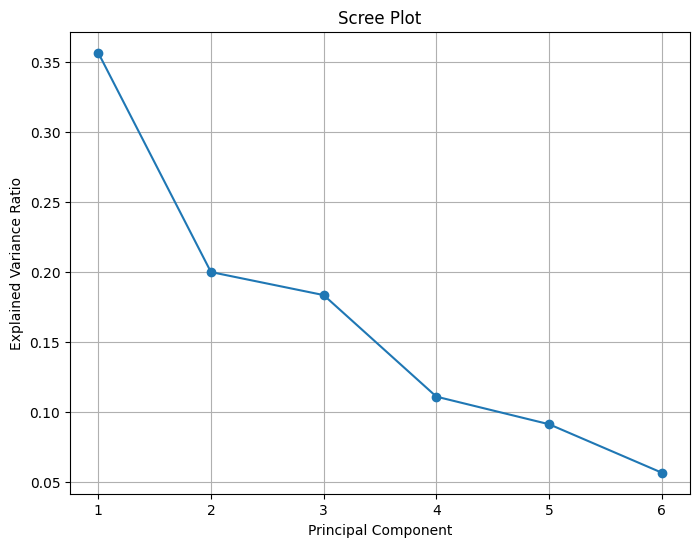

In [15]:
#Screeplot of variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca_res.explained_variance_ratio_) + 1), pca_res.explained_variance_ratio_, marker='o', linestyle='-')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(np.arange(1, len(pca_res.explained_variance_ratio_) + 1))
plt.grid(True)
plt.show()

### Visualizing principal components

A classic visualization of the relative contribution of the original variables to the principal components is a so-called *biplot*. For any pair of components, it consists of a scatter plot of the component values, with superimposed line plots that show the relative contribution of each variable to each of the components.

For example, a line plot that points to the upper-right quadrant in the scatter plot (e.g., `infants`) would indicate that the variable in question contributes positively to both components (note that the results may yield different signs for the loadings, depending on the method used). On the other hand, a line plot that points to the lower-right quadrant (e.g., `suicids`) would suggest a positive contribution to the first component, but a negative contribution to the second (on the y-axis).

Below, we illustrate the biplot by means of a simple function using a number of basic matplotlib plotting functions.

In the biplot below, we have re-scaled the loadings by multiplying them by 2 just so they get more visible in the graph.

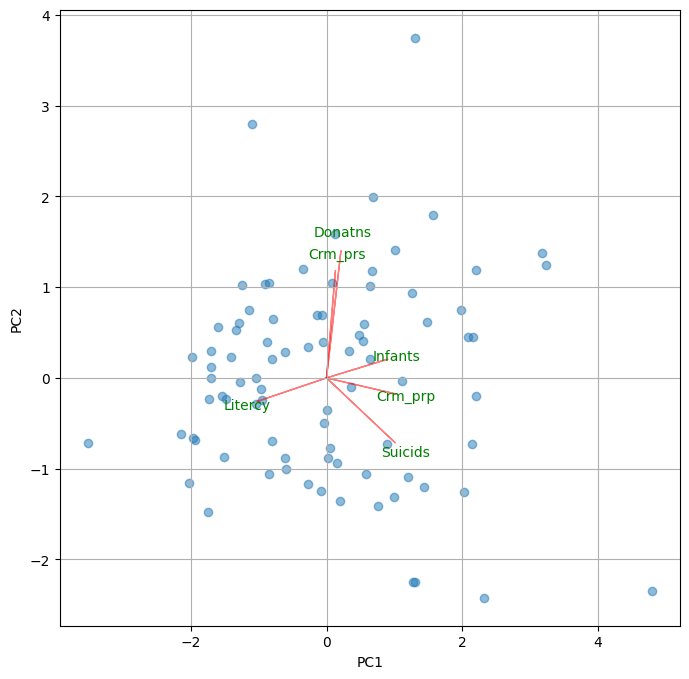

In [16]:
# Biplot
def biplot(score, coeff, labels=None):
    plt.figure(figsize=(8, 8))
    plt.scatter(score[:, 0], score[:, 1], alpha=0.5)
    for i in range(len(coeff)):
        plt.arrow(0, 0, coeff[i, 0], coeff[i, 1], color='r', alpha=0.5)
        if labels is None:
            plt.text(coeff[i, 0]*1.15, coeff[i, 1]*1.15, "Var" + str(i+1), color='g', ha='center', va='center')
        else:
            plt.text(coeff[i, 0]*1.15, coeff[i, 1]*1.15, labels[i], color='g', ha='center', va='center')
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()
    plt.show()

biplot(pca_res.transform(X)[:, :2], pca_res.components_.T*2, labels=data_pca.columns)

Other visualizations, such as the ones illustrated in the Spatial Clustering book can be pursued as well, including a parallel coordinate plot showing the contributions of different variables to a component. This is not further pursued here.

### Spatializing the PCA

As described in the Spatial Clustering book, there are several ways in which the results of a principal components calculation can be visualized. The basic idea is that a component (typically the first principal component) summarizes several underlying variables and therefore can be used as a proxy for multivariate relationships. In essence then, a univariate spatial visualization of a principal component provides insight into multivariate spatial patterns.

All the usual visualizations can be applied, such as various thematic maps and cluster maps from indicators of local spatial autocorrelation. Care must be taken in interpreting these results, since the sign of the loadings is indeterminate (so high can become low and vice versa). In addition, one can assess the similarity in results of a full multivariate approach, such as a multivariate local Geary or a neighbor match map and the univariate results for the principal component. This is not further pursued here.

We close the notebook with an illustration of a box map and a local moran cluster map for the first principal component.

#### Box map

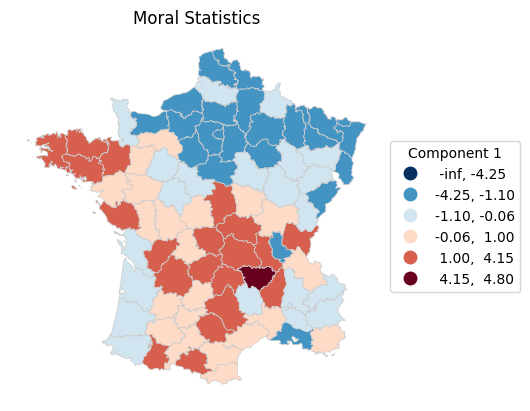

In [17]:
# Box map of Component 1:
dfs['Comp.1'] = pca_res.transform(X)[:, 0] 

ax = dfs.plot(
column = 'Comp.1',
scheme = "BoxPlot",
k = 6,
cmap='RdBu_r', 
linewidth=0.5, 
edgecolor='0.8',
legend = True,
legend_kwds={"loc":"center left","bbox_to_anchor":(1,0.5), "title": "Component 1"}
)
ax.set_title("Moral Statistics")
ax.set_axis_off()

#### Local Moran cluster map

We use `pygeoda` to compute the Local Moran statistic. This requires three steps:
- `open` the geodataframe
- create `queen_weights` from the geodataframe
- compute a `local_moran` object passing the weights and the variable

In our illustration, we use the first principal component.

The resulting `lisa object` contains the statistics, `lisa_values`, associated p-values, `lisa_pvalues`, the neighbor cardinality, `lisa_num_nbrs`, the cluster classification, based on a p-value of 0.05, `lisa_clusters`, labels, `lisa_labels`, and associated colors, `lisa_colors`.

In [18]:
dfs_g = pygeoda.open(dfs)
queen_w = pygeoda.queen_weights(dfs_g)
lm = pygeoda.local_moran(queen_w, dfs_g['Comp.1'])
lm

lisa object:

	lisa_values(): [-0.6005823808604229, 0.7471024909849964, 1.6210949461719373, 0.16767108746569154, 0.18513409990070004, 0.7124912049173785, 0.6074704091984993, 0.41650207972443176, 1.0429165705519907, 0.3603577787234622, ...]
	lisa_pvalues(): [0.216, 0.008, 0.004, 0.184, 0.334, 0.067, 0.034, 0.29, 0.012, 0.115, ...]
	lisa_num_nbrs(): [4, 6, 6, 4, 3, 7, 3, 3, 5, 5, ...]
	lisa_clusters(): [0, 2, 1, 0, 0, 0, 2, 0, 2, 0, ...]
	lisa_labels(): ('Not significant', 'High-High', 'Low-Low', 'Low-High', 'High-Low', 'Undefined', 'Isolated')
	lisa_colors(): ('#eeeeee', '#FF0000', '#0000FF', '#a7adf9', '#f4ada8', '#464646', '#999999')

With the usual commands, we create a custom local cluster map using the `lisa_colors` and `lisa_labels`.

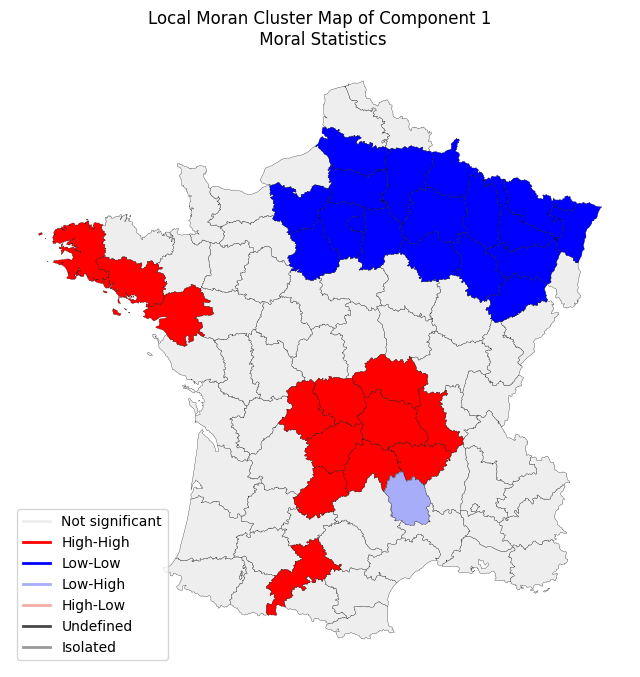

In [20]:
fig, ax = plt.subplots(figsize = (8,8))
lisa_colors = lm.lisa_colors()
lisa_labels = lm.lisa_labels()

dfs['LISA'] = lm.lisa_clusters()

for ctype, data in dfs.groupby('LISA'):
    color = lisa_colors[ctype]
    lbl = lisa_labels[ctype]
    data.plot(color = color,
        ax = ax,
        label = lbl,
        edgecolor = 'black',
        linewidth = 0.2)

# Place legend in the lower right hand corner of the plot
lisa_legend = [pltlines.Line2D([0], [0], color=color, lw=2) for color in lisa_colors]
ax.legend(lisa_legend, lisa_labels,loc='lower left', fontsize=10, frameon=True)
ax.set(title='Local Moran Cluster Map of Component 1\n Moral Statistics')
ax.set_axis_off()
